模型训练

三、多项式回归

1、学习曲线（验证过拟合或拟合不足的另一种方法）

复习：交叉验证【如果模型在训练集上表现良好但是在交叉集上表现不好则是过拟合；如果两者都表现不好，则是拟合不足】

解决方案

如果模型拟合不足，则添加更多的训练点也于事无补，你需要选择更复杂的模型。

如果模型过拟合，需要给算法投喂更多的数据。

2、模型的三种误差

（1）偏差：模型选择错误

（2）方差：模型的小扰动的敏感度

（3）不可约误差：噪声引起的偏差

增加模型的复杂度会增加方差，减少误差，可能会导致过拟合；降低模型的复杂度会减少方差，增加误差，可能会导致拟合不足。

四、正则化线性模型

用于训练的成本函数和用于测试的性能函数不同的原因：

1、服务于正则化的要求

2、成本函数应该具有对优化友好的导函数，而性能函数应尽可能接近于最终目标

在将训练集喂给模型前，需要将其标准化，因为正则化模型一般都对数据的尺度很敏感。

1、Ridge Regression

2、Lasso Regression(倾向于排除最不重要的特征，自动进行了特征筛选，输出稀疏模型)

3、Elastic net（介于Ridge拟合和Lasso拟合）

4、使用顺序：Ridge Regression是一个默认的好算法；

当面对只有很少的特征是对目标真正有用的情况时，优先选择Lasso Regression 或 Elastic net
当特征数大于训练点数或特征间具有强关联时，优先选择Elastic Net

5、规范梯度下降算法的方法：early stoping

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

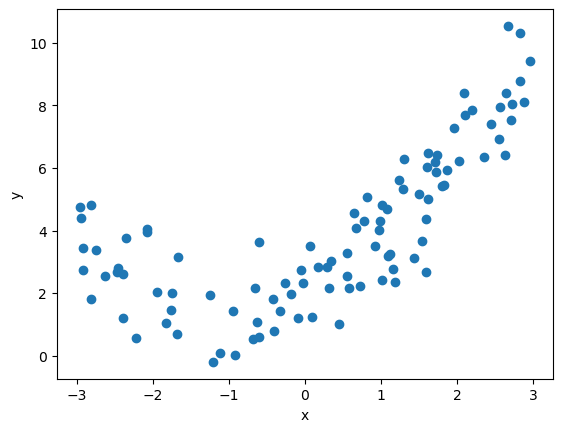

In [2]:
#生成用于训练的数据点
m = 100
X = 6 * np.random.rand(m, 1) - 3#随机生成范围为[-3,3]的m行1列的向量
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
plt.scatter(X,y)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [3]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)#最高的幂次为2次
X_poly = poly_features.fit_transform(X)#将原始数据变换为适合多项式拟合的数据（包含X和X^2）
print(X[0])
print(X_poly[0])

[0.08923907]
[0.08923907 0.00796361]


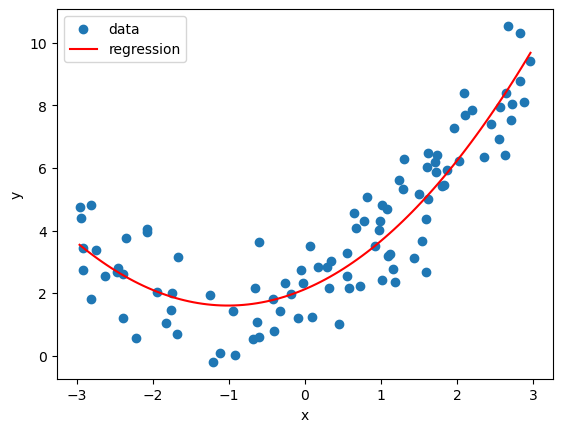

(array([2.12686922]), array([[1.03367692, 0.50971003]]))

In [4]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
plt.scatter(X,y,label="data")
plt.xlabel("x")
plt.ylabel("y")
X_line = np.linspace(X.min(), X.max(), 100).reshape(100, 1)  # 生成用于绘制的X值
X_line_poly = poly_features.transform(X_line)  # 对X_line应用多项式变换
y_line = lin_reg.predict(X_line_poly)  # 使用模型预测回归线对应的y值
plt.plot(X_line,y_line,label="regression",c="r")
plt.legend()
plt.show()
lin_reg.intercept_, lin_reg.coef_

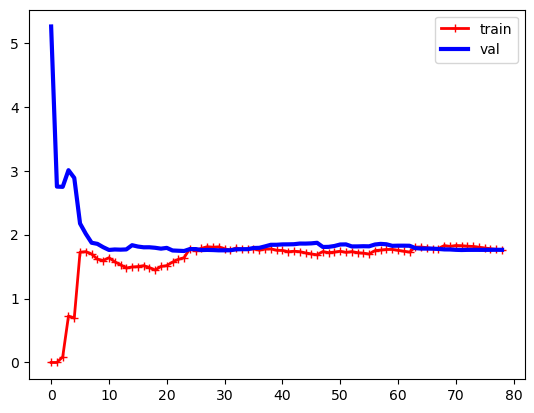

In [13]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
def plot_learning_curves(model, X, y):
 X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
 train_errors, val_errors = [], []
 for m in range(1, len(X_train)): #逐步增加训练集的数目
    model.fit(X_train[:m], y_train[:m])
    y_train_predict = model.predict(X_train[:m])
    y_val_predict = model.predict(X_val)
    train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
    val_errors.append(mean_squared_error(y_val_predict, y_val))
 plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
 plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
 plt.legend()
lin_reg=LinearRegression()
plot_learning_curves(lin_reg,X,y)

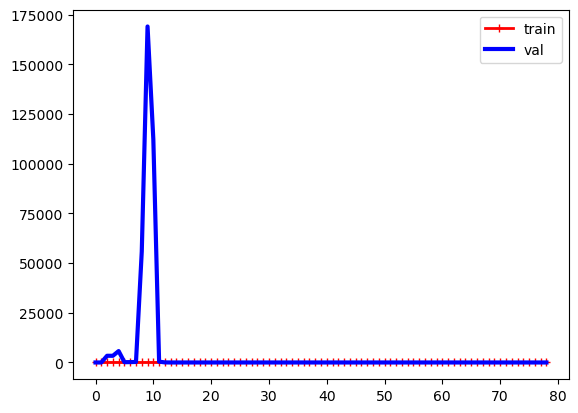

In [14]:
from sklearn.pipeline import Pipeline
polynomial_regression = Pipeline([
 ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
 ("lin_reg", LinearRegression()),
 ])
plot_learning_curves(polynomial_regression, X, y)

1、Ridge算法

In [15]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[5.18806644]])

In [16]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.16602452])

2、lasso算法

In [17]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([5.15139497])

In [18]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([5.17385394])

5、Early Stopping

In [21]:
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler
# prepare the data
poly_scaler = Pipeline([
 ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
 ("std_scaler", StandardScaler()) ])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)
sgd_reg = SGDRegressor(max_iter=1, warm_start=True, penalty=None,
 learning_rate="constant", eta0=0.0005)
minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000): #初始设定迭代1000次
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val_predict, y_val)
    if val_error < minimum_val_error:
        minimum_val_error = val_error #更新方差
        best_epoch = epoch #确定最佳迭代次数，防止随机梯度下降收敛到的最终模型过拟合
        best_model = clone(sgd_reg)#将训练出的最佳模型进行备份

c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\youyiting\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1575: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fi